# Athens Airbnb Inference Analysis of Listing Price

#### STAT 301 - Group 31: Angela Li, Tyler Yih, Rex Ren, Diamond Wang (Dec. 6th, 2025)

## Introduction

## 2. Scientific Question

#### Clearly state the question you want try to answer using the dataset

- We want to examine the association between the price of the accommodation for two people staying two nights (response) and predictors related to room characteristics (e.g. room type, number of bedrooms), location information (e.g. distance from city centre, longitude, latitude), and the attraction index.
- The response is `real_sum`, the price of the accommodation for two people staying two nights in Euros.
- Our question is primarily focused on inference, as we are identifying which features are associated with price and estimating their effects. We may build a predictive model later and keep our options open.

## Method and Results

### a) Data

#### Loading data

In [7]:
# Run this cell before continuing.
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(modelr)

In [11]:
# Airbnb data in Athens on weekdays
weekdays <- read_csv("data/athens_weekdays.csv", show_col_types = FALSE)
# Airbnb data in Athens on weekends
weekends <- read_csv("data/athens_weekends.csv", show_col_types = FALSE)

New names:
• `` -> `...1`
New names:
• `` -> `...1`


#### Source and information
- The data was collected with web-scraping done with the help of a web-automation framework (Selenium WebDriver) during a study done by Gyódi, Kristóf and Nawaro, Łukasz, and attractiveness was based on TripAdvisor data.
- The data, provided by the University of Warsaw, was used to collect Airbnb offers that would be presented to a real user.

#### Citation
- https://doi.org/10.5281/zenodo.4446043
- https://doi.org/10.1016/j.tourman.2021.104319

### Variables

#### Descriptive summary
- Our assigned dataset offers detailed information on Airbnb listings in Athens, Greece, for both weekdays and weekends.
- The weekdays dataset consists of 2,653 entries, and the weekends dataset consists of 2,627 entries.
- Both datasets have 20 variables, whose names, descriptions, and types are provided in the table below.

#### Pre-selection of variables
- We likely will drop `room_shared`, and `room_private,` as `room_type` has overlapping information with the booleans about the type of room in the listing.
- In addition, both `attr_index` and `rest_index` heavily overlap with their normalized counterparts, so we only need to use one; likely the normalized version, so we would drop `attr_index` and `rest_index`.
- The index column does not contain very useful information so we would drop that as well.
- Lastly, we will remove `lng` and `lat` since we don't cover spatial analysis in this course.

| Variable Name                 | Description                                                     | Type        |
|-------------------------------|-----------------------------------------------------------------|-------------|
| `(index)`                     | Index of the row in the table                                   | Numeric     |
| `realSum`                     | Full price of accommodation for two people and two nights (EUR) | Numeric     |
| `room_type`                   | Type of the accommodation                                       | Categorical |
| `room_shared`                 | Whether the room is shared                                      | Boolean     |
| `room_private`                | Whether the room is private                                     | Boolean     |
| `person_capacity`             | Maximum number of guests                                        | Numeric     |
| `host_is_superhost`           | Whether the host is a superhost                                 | Boolean     |
| `multi`                       | Whether the listing belongs to hosts with 2-4 offers            | Boolean     |
| `biz`                         | Whether the listing belongs to hosts with more than 4 offers    | Boolean     |
| `cleanliness_rating`          | Cleanliness rating of the listing                               | Numeric     |
| `guest_satisfaction_overall`  | Overall guest satisfaction rating                               | Numeric     |
| `bedrooms`                    | Number of bedrooms in the listing (0 for studios)               | Numeric     |
| `dist`                        | Distance from the city centre (km)                              | Numeric     |
| `metro_dist`                  | Distance from the nearest metro station (km)                    | Numeric     |
| `attr_index`                  | Attraction index of the listing location                        | Numeric     |
| `attr_index_norm`             | Normalized attraction index (0-100)                             | Numeric     |
| `rest_index`                  | Restaurant index of the listing location                        | Numeric     |
| `rest_index_norm`             | Normalized restaurant index (0-100)                             | Numeric     |
| `lng`                         | Longitude of the listing location                               | Numeric     |
| `lat`                         | Latitude of the listing location                                | Numeric     |


### b) Exploratory Data Analysis (EDA)

#### Clean/wrangling data

In [9]:
# combine weekday and weekend datasets, creating new 
athens_raw <- bind_rows(
  mutate(weekdays, day_type = "weekday"),
  mutate(weekends, day_type = "weekend")
)

head(athens_raw)

...1,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,⋯,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,day_type
<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,129.82448,Entire home/apt,FALSE,FALSE,4,FALSE,0,0,10,⋯,2,2.8139635,0.8818900,55.34857,2.086871,78.77838,5.915160,23.76600,37.98300,weekday
1,138.96375,Entire home/apt,FALSE,FALSE,4,TRUE,1,0,10,⋯,1,0.4072929,0.3045679,240.30665,9.060559,407.16770,30.572629,23.73168,37.97776,weekday
2,156.30492,Entire home/apt,FALSE,FALSE,3,TRUE,0,1,10,⋯,1,1.2372111,0.2884881,199.50737,7.522257,395.96740,29.731642,23.72200,37.97900,weekday
3,91.62702,Entire home/apt,FALSE,FALSE,4,TRUE,1,0,10,⋯,1,4.3674572,0.2974673,39.80305,1.500740,58.70658,4.408047,23.72712,38.01435,weekday
4,74.05151,Private room,FALSE,TRUE,2,FALSE,0,0,10,⋯,1,2.1941850,0.3852657,78.73340,2.968577,113.32597,8.509204,23.73391,37.99529,weekday
5,113.88934,Entire home/apt,FALSE,FALSE,6,TRUE,1,0,10,⋯,2,2.0712056,0.4538674,96.58899,3.641806,158.64432,11.911981,23.71584,37.98598,weekday


In [17]:
athens <- bind_rows(
  # bind the two datasets together into a single tibble
  mutate(weekdays, day_type = "weekday"),
  mutate(weekends, day_type = "weekend")
) |>
  mutate(
    day_type = factor(day_type, levels = c("weekday", "weekend"))
  ) |> # make day_type a factor
  select(-room_shared, -room_private, -`...1`, -lng, -lat) |> # drop columns discussed in Section 1; NOTE: longitude and latitude dropped now
  rename(real_sum = realSum) |>
  mutate(
    room_type = str_squish(room_type),
    room_type = factor(
      room_type,
      levels = c("Entire home/apt", "Private room", "Shared room")
    ),
    room_type = fct_recode(
      room_type,
      "entire" = "Entire home/apt",
      "private" = "Private room",
      "shared" = "Shared room"
    )
  ) |>
  mutate(
    num_host_offers = case_when(
      biz == 1 ~ "moreThanFour",
      multi == 1 ~ "twoToFour",
      TRUE ~ "one"
    ),
    num_host_offers = factor(
      num_host_offers,
      levels = c("moreThanFour", "twoToFour", "one")
    ) # combine biz and multi into a single categorical column
  ) |>
  select(-multi, -biz)

head(athens)
summary(athens$real_sum)

## this is Angela's wrangling code , im mostly just confused why urs is like way more convoluted in the middle and idk why
# athens <- athens_raw %>%
#     mutate(
#     # convert room_type to factor
#     room_type = fct_recode(room_type,
#                             "entire" = "Entire home/apt",
#                             "private" = "Private room",
#                             "shared" = "Shared room"),
#     # convert day_type to factor
#     day_type = as_factor(day_type),
    
#     # create a new categorical column 'num_host_offers'
#     num_host_offers = case_when(
#       biz == 1 ~ "moreThanFour",
#       multi == 1 ~ "twoToFour",
#       TRUE ~ "one"
#     ),
    
#     # make num_host_offers a factor
#     num_host_offers = as_factor(num_host_offers)
#     ) %>% 

#     # remove index, room_shared, room_private, multi, biz, attr_index and rest_index
#     select(-...1, -room_shared, -room_private, -multi, -biz, -attr_index, -rest_index)

# head(athens)

real_sum,room_type,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,day_type,num_host_offers
<dbl>,<fct>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
129.82448,entire,4,FALSE,10,100,2,2.8139635,0.8818900,55.34857,2.086871,78.77838,5.915160,weekday,one
138.96375,entire,4,TRUE,10,96,1,0.4072929,0.3045679,240.30665,9.060559,407.16770,30.572629,weekday,twoToFour
156.30492,entire,3,TRUE,10,98,1,1.2372111,0.2884881,199.50737,7.522257,395.96740,29.731642,weekday,moreThanFour
91.62702,entire,4,TRUE,10,99,1,4.3674572,0.2974673,39.80305,1.500740,58.70658,4.408047,weekday,twoToFour
74.05151,private,2,FALSE,10,100,1,2.1941850,0.3852657,78.73340,2.968577,113.32597,8.509204,weekday,one
113.88934,entire,6,TRUE,10,96,2,2.0712056,0.4538674,96.58899,3.641806,158.64432,11.911981,weekday,twoToFour


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   42.88    98.66   127.72   151.74   171.54 18545.45 

#### Visualizations

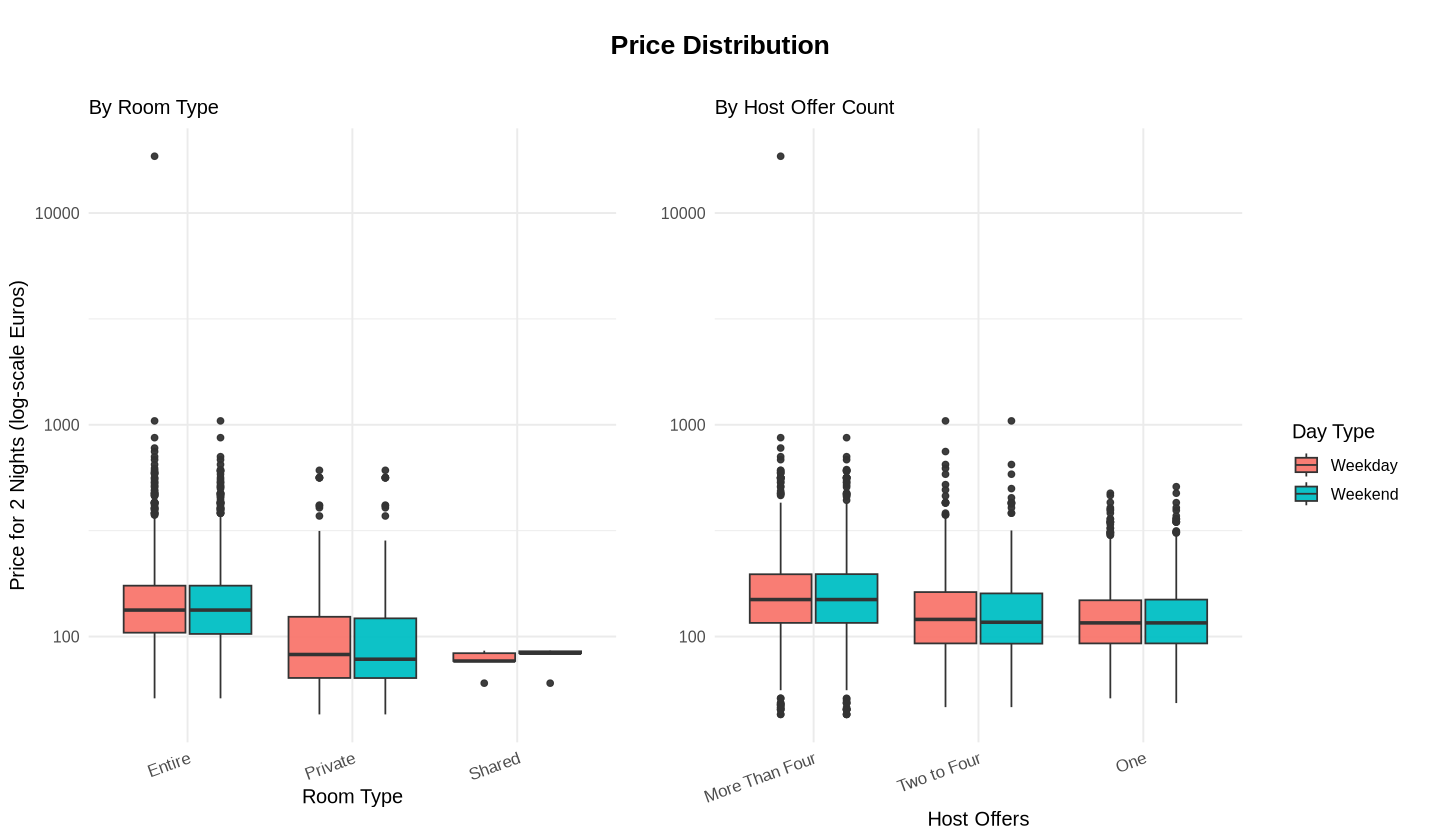

In [18]:
options(repr.plot.width = 12, repr.plot.height = 7)
p1 <- ggplot(athens, aes(x = room_type, y = real_sum, fill = day_type)) +
  geom_boxplot(position = position_dodge(width = 0.8), alpha = 0.95) +
  scale_y_log10() +
  scale_x_discrete(labels = function(x) str_to_title(x)) +
  scale_fill_discrete(labels = function(x) str_to_title(x)) +
  labs(
    x = "Room Type",
    y = "Price for 2 Nights (log-scale Euros)",
    fill = "Day Type"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    legend.position = "top",
    strip.text = element_text(face = "bold"),
    plot.title = element_text(hjust = 0.5, size = 14, margin = margin(b = 10)),
    axis.text.x = element_text(angle = 20, vjust = 1, hjust = 1, size = 10)
  )

p2 <- ggplot(athens, aes(x = num_host_offers, y = real_sum, fill = day_type)) +
  geom_boxplot(position = position_dodge(width = 0.8), alpha = 0.95) +
  scale_y_log10() +
  scale_x_discrete(
    labels = function(x) case_when(
      x == "moreThanFour" ~ "More Than Four",
      x == "one" ~ "One",
      x == "twoToFour" ~ "Two to Four",
      TRUE ~ str_to_title(x)
    )) +
  scale_fill_discrete(labels = function(x) str_to_title(x)) +
  labs(
    x = "Host Offers",
    y = NULL,
    fill = "Day Type"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    legend.position = "top",
    strip.text = element_text(face = "bold"),
    plot.title = element_text(hjust = 0.5, size = 14, margin = margin(b = 10)),
    axis.text.x = element_text(angle = 20, vjust = 1, hjust = 1, size = 10)
  )

legend <- get_legend(p1 + theme(legend.position = "right"))

plot_grid(
  ggdraw() + 
    draw_label(
      "Price Distribution", 
      fontface = 'bold', 
      x = 0.5, 
      hjust = 0.5,
      size = 16
    ),
  plot_grid(
    plot_grid(
      p1 + labs(subtitle = "By Room Type", title = NULL) + theme(legend.position = "none"),
      p2 + labs(subtitle = "By Host Offer Count", title = NULL) + theme(legend.position = "none"),
      ncol = 2,
      align = "hv",
      axis = "tblr",
      rel_widths = c(1, 1)
    ),
    legend,
    ncol = 2,
    rel_widths = c(1, 0.15)
  ),
  ncol = 1,
  rel_heights = c(0.12, 1)
)

#### Provide the following Interpretations

##### Explain why you consider this plot relevant to address your question or to explore the data.
- This plot is relevant because it shows how the response (`real_sum`) varies across two key categorical predictors (`room_type` and `num_host_offers`), and how that relationship shifts by `day_type`.
- Using boxplots on a log10 y-scale makes the skewed price distribution easier to compare and helps spot group-level differences and heteroscedasticity that are important for later inference.
##### Interpret briefly the results obtained.
- `entire` Airbnb offers show substantially higher medians and much wider variability than `private` or `shared` offerings, and the `entire` category contains extreme high-price outliers that extend far above the rest of the distribution.
- `shared` appears very narrow and has few observations.
- <mark>Lastly, we notice the two `day_type` fills is <mark>associated with</mark> only small within-group shifts in medians, suggesting weekday/weekend differences exist but are not huge in these raw comparisons.</mark>
##### Interpret briefly the results obtained.
- The visualization suggests `room_type` and `num_host_offers` are promising predictors to include (and possibly interact) in a regression for inference, and it justifies the log-transform of price.
- It also reveals various problems to address in modelling, such as strong right skew and outliers, unequal group sizes, and confounding from variables that we haven't explored yet.
- The next steps are to check sample sizes per cell, examine covariate balance, and build a model using relevant features.

#### Visualizing data

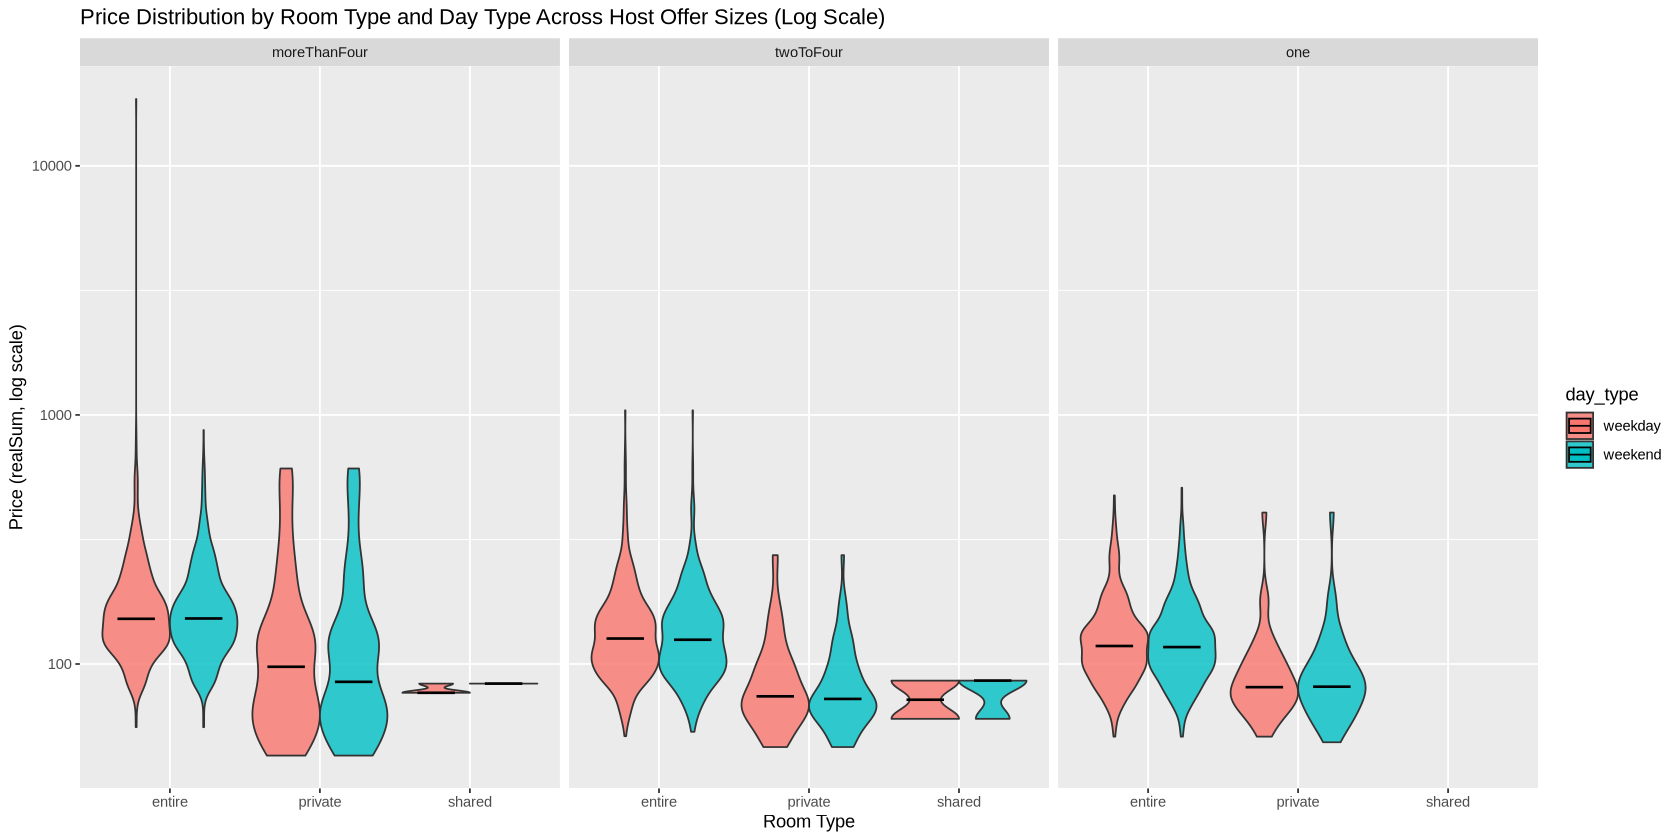

In [24]:
options(repr.plot.width = 14, repr.plot.height = 7)

ggplot(athens, aes(x = room_type, y = real_sum, fill = day_type)) +
  geom_violin(scale = "width", trim = TRUE, alpha = 0.8, position = position_dodge(width = 0.9)) +
  stat_summary(
    fun = median,
    geom = "crossbar",
    width = 0.5,
    color = "black",
    fatten = 1.5,
    position = position_dodge(width = 0.9)
  ) +
  scale_y_log10() +
  facet_wrap(~ num_host_offers) +
  labs(
    title = "Price Distribution by Room Type and Day Type Across Host Offer Sizes (Log Scale)",
    y = "Price (realSum, log scale)",
    x = "Room Type"
  )

#### Relevance
- This plot is relevant to address my question and explores the data because it visually explores how accommodation prices (realSum) vary by room type, weekday vs weekend, and number of host offers, which are all key variables related to room characteristics and timing of stay which may influence pricing.
- Faceting by host offer size allows us to compare pricing patterns across hosts with few versus many listings and look at the variability across the categories.

#### Interpretation of Results
- The original data is heavily right-skewed, so we log-transformed the price axis to reduce skewness.
- For weekday vs. weekend, price distributions are similar for some room type x host offer size combinations (e.g., entire rooms or private rooms with one or two-to-four listings) and show small differences for others (e.g. shared rooms or private rooms with more-than-four listings), while for room type, entire homes remain the most expensive and shared and private rooms have lower, more stable prices.
- The violin plots reveal that price distributions across room types deviate from normality, as several have long upper tails, and some show two distinct peaks, indicating bimodality.

#### What is Learned
- Price does not appear to differ consistently between weekdays and weekends, whereas room type shows a clearer relationship with price.
- A prominent outlier in the weekday × entire room × more-than-four-listings category suggests an unusually high-priced property that could distort model estimates if not addressed.
- The long upper tails in several distributions, even on the log scale, indicate residual skewness and possible heteroskedasticity, which could violate regression assumptions and should be considered in modeling.

### d) Method and Plan 

#### Proposed method (one-line)
- **Multiple linear regression (MLR)** on `log(real_sum)` using `room_type`, `person_capacity`, `host_is_superhost`, `cleanliness_rating`, `guest_satisfaction_overall`, `bedrooms`, `dist`, `metro_dist`, `attr_index`, `rest_index`, `rest_index_norm` and `num_host_offers`.

#### Why is this method appropriate?
- MLR directly estimates associations between multiple predictors and the (transformed) price while producing interpretable effect estimates and hypothesis tests.  
- Log-transforming `real_sum` stabilizes variance and turns multiplicative effects into additive ones, so coefficients approximate percent changes (this is convenient for skewed price data).

#### Which assumptions are required?
- Linearity: the predictors relate linearly to `log(real_sum)`, and the errors are independent with mean zero. 
- We are assuming homoskedasticity and normality of residuals for valid standard inference, as well as low multicollinearity among predictors, for stable coefficient estimates.

#### Potential limitations or weaknesses
- While log-transform helps, mutliers and heavy right skew can still influence estimates.
- Heteroskedasticity or non-normal errors would invalidate standard SEs.  
- Omitted confounders (e.g. spatial clustering) can make some coefficients unstable or biased.

### e) Code and Results

In [25]:
mlr_fit <- lm(formula = log(real_sum) ~ . - day_type, data = athens)

mlr_res <- tidy(mlr_fit, conf.int = TRUE) |>
    mutate_if(is.numeric, round, 2)

mlr_res

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.92,0.06,64.04,0.00,3.80,4.04
room_typeprivate,-0.27,0.02,-15.01,0.00,-0.30,-0.23
room_typeshared,-0.50,0.10,-5.08,0.00,-0.70,-0.31
person_capacity,0.07,0.00,14.90,0.00,0.06,0.08
host_is_superhostTRUE,0.03,0.01,2.79,0.01,0.01,0.05
cleanliness_rating,0.05,0.01,6.41,0.00,0.04,0.07
guest_satisfaction_overall,0.00,0.00,1.41,0.16,0.00,0.00
bedrooms,0.12,0.01,13.43,0.00,0.10,0.14
dist,-0.07,0.01,-10.79,0.00,-0.08,-0.06


#### Interpretation of Results

- **Expected associations:** `room_type = private` and `room_type = shared` are priced significantly lower than `room_type = entire`, and price increases with `person_capacity`, `bedrooms`, `cleanliness_rating`, and stronger `attr_index` / `rest_index`, while greater `dist` and `metro_dist` reduce price; these patterns directly address our inferential question by identifying which room and location features are meaningfully associated with accommodation price.  
- **Other effects:** `host_is_superhost = TRUE` carries a small but statistically significant price premium, whereas `guest_satisfaction_overall` is not significant, suggesting limited additional explanatory value once other factors are included.  
- **Significance and uncertainty:** Most predictors have very small p-values and narrow 95% confidence intervals, indicating precise and robust estimates for the variables associated with price.  
- **Multicollinearity issue and remedies:** The opposing signs and large magnitudes of `attr_index` and `attr_index_norm`, despite both being highly significant, indicate multicollinearity and unstable individual estimates; this can be addressed by checking VIFs or applying regularization (ridge/lasso).

## Discussion

## References